In [1]:
! nvidia-smi

Tue Jun  9 16:43:35 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0    31W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
# # Colab
# ! pip install fastai2 -q
# ! pip install pydicom -q
# ! pip install kornia -q

In [0]:
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.vision.all import *
from fastai2.medical.imaging import *

import pydicom

import pandas as pd

In [5]:
dataset = 'jesperdramsch/siim-acr-pneumothorax-segmentation-data'

# Google Colab
config_path = Path('/content/drive')
learner_path = config_path/"My Drive"
data_path_base = Path('/content/datasets/')

path = data_path_base/dataset

from google.colab import drive

drive.mount(str(config_path))
os.environ['KAGGLE_CONFIG_DIR'] = f"{config_path}/My Drive/.kaggle"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# !kaggle datasets download {dataset} -p "{path}" --unzip

In [7]:
path.ls()

(#4) [Path('/content/datasets/jesperdramsch/siim-acr-pneumothorax-segmentation-data/train-rle.csv'),Path('/content/datasets/jesperdramsch/siim-acr-pneumothorax-segmentation-data/dicom-images-train'),Path('/content/datasets/jesperdramsch/siim-acr-pneumothorax-segmentation-data/dicom-images-test'),Path('/content/datasets/jesperdramsch/siim-acr-pneumothorax-segmentation-data/pneumothorax')]

In [8]:
(path/'dicom-images-train').ls()

(#10712) [Path('/content/datasets/jesperdramsch/siim-acr-pneumothorax-segmentation-data/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.1214.1517875166.812239'),Path('/content/datasets/jesperdramsch/siim-acr-pneumothorax-segmentation-data/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.32520.1517875160.990398'),Path('/content/datasets/jesperdramsch/siim-acr-pneumothorax-segmentation-data/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.14480.1517875252.313836'),Path('/content/datasets/jesperdramsch/siim-acr-pneumothorax-segmentation-data/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.14548.1517875252.639694'),Path('/content/datasets/jesperdramsch/siim-acr-pneumothorax-segmentation-data/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.3151.1517875176.339181'),Path('/content/datasets/jesperdramsch/siim-acr-pneumothorax-segmentation-data/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.31650.1517875156.50389'),Path('/content/datasets/jesperdramsch/siim-acr-pneumothorax-seg

In [9]:
items = get_dicom_files(path/'dicom-images-train')
items

(#10712) [Path('/content/datasets/jesperdramsch/siim-acr-pneumothorax-segmentation-data/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.1214.1517875166.812239/1.2.276.0.7230010.3.1.3.8323329.1214.1517875166.812238/1.2.276.0.7230010.3.1.4.8323329.1214.1517875166.812240.dcm'),Path('/content/datasets/jesperdramsch/siim-acr-pneumothorax-segmentation-data/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.32520.1517875160.990398/1.2.276.0.7230010.3.1.3.8323329.32520.1517875160.990397/1.2.276.0.7230010.3.1.4.8323329.32520.1517875160.990399.dcm'),Path('/content/datasets/jesperdramsch/siim-acr-pneumothorax-segmentation-data/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.14480.1517875252.313836/1.2.276.0.7230010.3.1.3.8323329.14480.1517875252.313835/1.2.276.0.7230010.3.1.4.8323329.14480.1517875252.313837.dcm'),Path('/content/datasets/jesperdramsch/siim-acr-pneumothorax-segmentation-data/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.14548.1517875252.639694/1.2.276.0.7230010.3.1.3.832

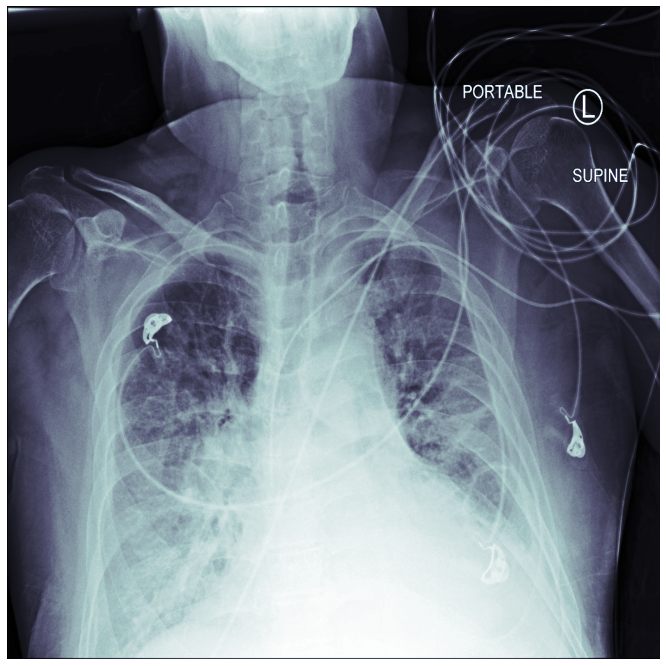

In [10]:
patient = 5555
xray_sample = dcmread(items[patient])
xray_sample.show(figsize=(12, 12))

In [11]:
xray_sample.as_dict()

{'AccessionNumber': '',
 'BitsAllocated': 8,
 'BitsStored': 8,
 'BodyPartExamined': 'CHEST',
 'Columns': 1024,
 'ConversionType': 'WSD',
 'HighBit': 7,
 'InstanceNumber': 1,
 'LossyImageCompression': '01',
 'LossyImageCompressionMethod': 'ISO_10918_1',
 'Modality': 'CR',
 'MultiPixelSpacing': 1,
 'PatientAge': '59',
 'PatientBirthDate': '',
 'PatientID': 'dbe48f63-d544-4fae-bd9f-16c9827ca536',
 'PatientName': 'dbe48f63-d544-4fae-bd9f-16c9827ca536',
 'PatientOrientation': '',
 'PatientSex': 'M',
 'PhotometricInterpretation': 'MONOCHROME2',
 'PixelRepresentation': 0,
 'PixelSpacing': 0.139,
 'PixelSpacing1': 0.139,
 'ReferringPhysicianName': '',
 'Rows': 1024,
 'SOPClassUID': '1.2.840.10008.5.1.4.1.1.7',
 'SOPInstanceUID': '1.2.276.0.7230010.3.1.4.8323329.12984.1517875242.874361',
 'SamplesPerPixel': 1,
 'SeriesDescription': 'view: AP',
 'SeriesInstanceUID': '1.2.276.0.7230010.3.1.3.8323329.12984.1517875242.874359',
 'SeriesNumber': 1,
 'SpecificCharacterSet': 'ISO_IR 100',
 'StudyDate':

In [12]:
xray_sample.pixels.shape

torch.Size([1024, 1024])

In [13]:
xray_sample.pixels.min(), xray_sample.pixels.max(), xray_sample.scaled_px.min(), xray_sample.scaled_px.max()

(tensor(0.), tensor(255.), tensor(0.), tensor(255.))

In [14]:
xray_sample.pixels[300:310, 400:410]

tensor([[111., 108., 111., 112., 108., 105., 108., 111., 112., 110.],
        [111., 110., 113., 115., 111., 108., 108., 108., 109., 110.],
        [109., 109., 112., 114., 112., 110., 110., 108., 106., 109.],
        [108., 107., 109., 110., 109., 111., 113., 111., 105., 108.],
        [104., 108., 110., 109., 110., 112., 112., 109., 108., 107.],
        [108., 111., 112., 111., 111., 113., 112., 109., 107., 106.],
        [108., 111., 112., 111., 111., 112., 111., 109., 108., 107.],
        [108., 109., 110., 110., 110., 112., 111., 110., 109., 108.],
        [109., 110., 111., 111., 111., 112., 112., 111., 108., 107.],
        [110., 110., 110., 110., 110., 110., 109., 109., 109., 108.]])

In [15]:
xray_sample.scaled_px[300:310, 400:410]

tensor([[111., 108., 111., 112., 108., 105., 108., 111., 112., 110.],
        [111., 110., 113., 115., 111., 108., 108., 108., 109., 110.],
        [109., 109., 112., 114., 112., 110., 110., 108., 106., 109.],
        [108., 107., 109., 110., 109., 111., 113., 111., 105., 108.],
        [104., 108., 110., 109., 110., 112., 112., 109., 108., 107.],
        [108., 111., 112., 111., 111., 113., 112., 109., 107., 106.],
        [108., 111., 112., 111., 111., 112., 111., 109., 108., 107.],
        [108., 109., 110., 110., 110., 112., 111., 110., 109., 108.],
        [109., 110., 111., 111., 111., 112., 112., 111., 108., 107.],
        [110., 110., 110., 110., 110., 110., 109., 109., 109., 108.]])

In [16]:
xray_sample.pixels.freqhist_bins()

tensor([  0.,   2.,   4.,   5.,   6.,   7.,   9.,  11.,  15.,  21.,  30.,  36.,
         42.,  47.,  50.,  53.,  55.,  58.,  61.,  63.,  66.,  68.,  70.,  72.,
         73.,  74.,  76.,  77.,  78.,  80.,  81.,  82.,  84.,  85.,  86.,  87.,
         89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99., 100.,
        101., 102., 103., 104., 105., 106., 107., 108., 110., 111., 112., 113.,
        115., 116., 117., 119., 121., 122., 124., 126., 127., 129., 131., 132.,
        134., 135., 137., 139., 140., 142., 144., 146., 149., 151., 154., 158.,
        161., 164., 166., 169., 172., 175., 178., 181., 184., 187., 190., 196.,
        246.])

In [17]:
dicom_windows

namespace(abdomen_soft=(400, 50), brain=(80, 40), brain_bone=(2800, 600), brain_soft=(375, 40), liver=(150, 30), lungs=(1500, -600), mediastinum=(350, 50), spine_bone=(1800, 400), spine_soft=(250, 50), stroke=(8, 32), subdural=(254, 100))

In [0]:
# xray_sample.pct_in_window??

In [19]:
xray_sample.pct_in_window(*dicom_windows.brain)

0.3305187225341797

In [20]:
xray_sample.pct_in_window(*dicom_windows.lungs)

0.8480339050292969

In [21]:
xray_sample.pct_in_window(*dicom_windows.mediastinum)

0.9986677169799805

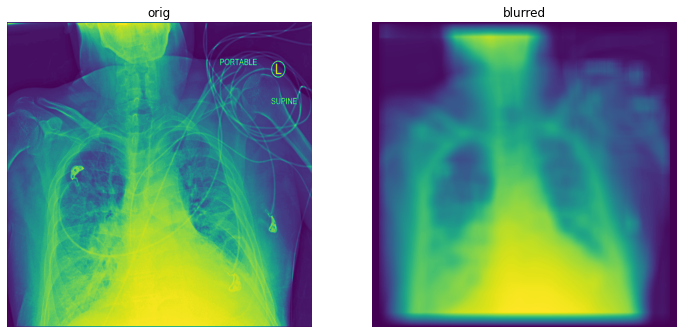

In [22]:
ims = xray_sample.hist_scaled(), uniform_blur2d(xray_sample.hist_scaled(),50)
show_images(ims, titles=('orig', 'blurred'), figsize=(12, 6))

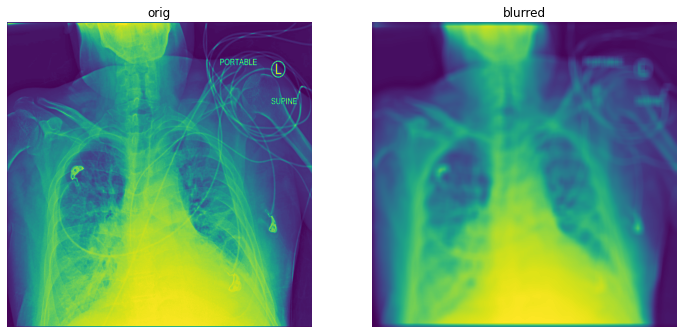

In [23]:
ims = xray_sample.hist_scaled(), gauss_blur2d(xray_sample.hist_scaled(),50)
show_images(ims, titles=('orig', 'blurred'), figsize=(12, 6))

In [0]:
# xray_sample.mask_from_blur??

In [0]:
wind = xray_sample.windowed(*dicom_windows.lungs)
mask1 = xray_sample.mask_from_blur(dicom_windows.lungs)
mask2 = xray_sample.mask_from_blur(dicom_windows.spine_soft)
mask3 = xray_sample.mask_from_blur(dicom_windows.liver)

_,ax = subplots(2,2, figsize=(12, 12))
ax = ax.reshape(-1)
show_image(wind, ax=ax[0])
show_image(wind, ax=ax[1])
show_image(wind, ax=ax[2])
show_image(wind, ax=ax[3])

show_image(mask1, alpha=0.5, cmap=plt.cm.Reds, ax=ax[1], title="lungs");
show_image(mask2, alpha=0.5, cmap=plt.cm.Reds, ax=ax[2], title="spine_soft");
show_image(mask3, alpha=0.5, cmap=plt.cm.Reds, ax=ax[3], title="liver");

In [0]:
xray_sample.show(cmap=plt.cm.gist_ncar, figsize=(12, 12))

In [0]:
mask = mask1
bbs = mask2bbox(mask)
bbs

In [0]:
lo,hi = bbs
show_image(wind[lo[0]:hi[0],lo[1]:hi[1]], figsize=(12, 12));

In [0]:
df = pd.read_csv(path/'train-rle.csv')
df.head()

In [0]:
# sorting by first name 
df.sort_values("ImageId", inplace = True) 
  
# dropping ALL duplicte values 
df.drop_duplicates(subset ="ImageId", 
                     keep = 'first', inplace = True) 
  

In [0]:
df.iloc[1, 1]

In [0]:
df.loc[df.iloc[:, 1] == ' -1', 'label'] = "Normal"
df.loc[df.iloc[:, 1] != ' -1', 'label'] = "Pneumothorax"

df.sample(5)

In [0]:
df = df.drop(df.columns[[1]], axis=1)
df.head()

In [0]:
df['label'].value_counts()

In [0]:
df[df['ImageId'] == '1.2.276.0.7230010.3.1.4.8323329.32579.1517875161.299312']

In [0]:
df[df['ImageId'] == '1.2.276.0.7230010.3.1.4.8323329.32579.1517875161.299312'].label.values[0]

In [0]:
df[df['ImageId'] == '1.2.276.0.7230010.3.1.4.8323329.10000.1517875220.938530'].label.values[0]

In [0]:
def label_func(fn):        
    lbl = df[df['ImageId'] == fn.stem].label.to_numpy()
    if len(lbl) == 0 : return "Normal"
    return lbl[0]

In [0]:
pneumothorax = DataBlock(blocks=(ImageBlock(cls=PILDicom), CategoryBlock), 
                         get_items=get_dicom_files, 
                         get_y=label_func, 
                         batch_tfms=[*aug_transforms(size=224)]
                         )

In [0]:
# pneumothorax.summary(path/'dicom-images-train')
dls = pneumothorax.dataloaders(path/'dicom-images-train', bs=64)
dls.show_batch(max_n=16)

In [0]:
dls.vocab

In [0]:
learn = cnn_learner(dls, resnet34, metrics=accuracy, 
                    cbs=[ShowGraphCallback])

In [0]:
learn.fine_tune(6)

In [0]:
weight = torch.tensor([[0.2]*1 + [0.8]]).cuda()

In [0]:
learn = cnn_learner(dls, resnet34, metrics=accuracy, 
                    loss_func=CrossEntropyLossFlat(weight=weight), 
                    cbs=[ShowGraphCallback])

In [0]:
learn.fine_tune(6)

# Credit

* https://dev.fast.ai/medical.imaging
* https://www.kaggle.com/jhoward/don-t-see-like-a-radiologist-fastai
* https://www.kaggle.com/jhoward/some-dicom-gotchas-to-be-aware-of-fastai
* https://www.kaggle.com/jesperdramsch/siim-acr-pneumothorax-segmentation-data
* https://github.com/fastai/fastai2/blob/master/nbs/61_tutorial.medical_imaging.ipynb
* 